In [ ]:
pip install transformers torch


In [ ]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('/content/drive/MyDrive/final.csv', encoding='mac_roman')

# Display the first few rows to understand the structure
print(df.head())


   Index                                        Description
0      1  A devastating wildfire swept through the outsk...
1      2  In a groundbreaking achievement, scientists ha...


In [ ]:
text_data = df['Description']

In [ ]:
# Load the sentiment analysis model
sentiment_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_model = pipeline('sentiment-analysis', model=sentiment_model_name)

In [ ]:
# Load the intensity analysis model (using BERT for regression)
intensity_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(intensity_model_name)
intensity_model = BertForSequenceClassification.from_pretrained(intensity_model_name, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def analyze_sentiment(text_data):
    # Ensure each input is a string and analyze sentiment
    result = sentiment_model(text_data)[0] if isinstance(text_data, str) else {}
    return result

In [ ]:
import torch
def analyze_intensity(text, sentiment_label):
    if isinstance(text, str) and text.strip():
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)
        with torch.no_grad():
            outputs = intensity_model(**inputs)
        intensity_score = outputs.logits.item()

        # Normalize to [-1, 1] using tanh function
        intensity = torch.tanh(torch.tensor(intensity_score)).item()

        # Adjust intensity to align with sentiment
        if sentiment_label == 'NEGATIVE':
            intensity = -abs(intensity)
        else:
            intensity = abs(intensity)

        return round(intensity, 2)
    else:
        return None

In [ ]:
df['sentiment'] = text_data.apply(lambda x: analyze_sentiment(x).get('label'))
df['sentiment_score'] = text_data.apply(lambda x: analyze_sentiment(x).get('score'))

# Then perform intensity analysis, using the sentiment from each row
df['intensity'] = df.apply(lambda row: analyze_intensity(row['Description'], row['sentiment']), axis=1)

In [ ]:
# Save the results to a new CSV file
df.to_csv('/content/drive/MyDrive/sentimental_analysis/final_output_with_sentiments_and_intensity.csv', index=False)

print("Sentiment and intensity analysis completed and results saved to 'output_with_sentiments_and_intensity.csv'")

Sentiment and intensity analysis completed and results saved to 'output_with_sentiments_and_intensity.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sentimental_analysis/final_output_with_sentiments_and_intensity.csv')


In [ ]:
X = df[['sentiment_score', 'intensity']].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Initialize DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(X_scaled)

# Get the cluster labels
labels = db.labels_

# Add the cluster labels to the DataFrame
df['cluster'] = labels

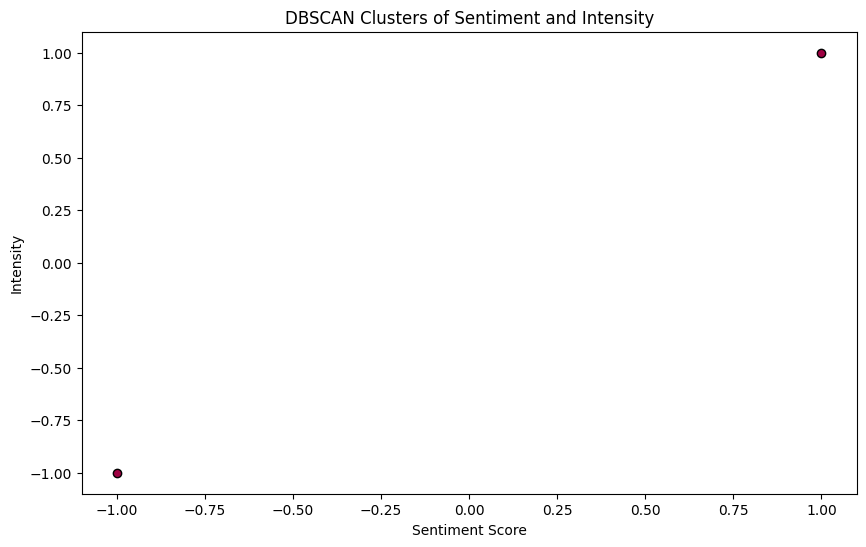

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = X_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=color, markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clusters of Sentiment and Intensity')
plt.xlabel('Sentiment Score')
plt.ylabel('Intensity')
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/sentimental_analysis/final_with_pattern.csv', index=False)
print("Pattern recognition completed and results saved to 'output_with_patterns.csv")

Pattern recognition completed and results saved to 'output_with_patterns.csv
